In [7]:
from timeit import default_timer as timer
import torch
import torch.nn as nn
from models import vgg,layers
import torch.utils.benchmark as benchmark
from torch.profiler import profile, record_function, ProfilerActivity

In [8]:
def manual_seed(seed):
    torch.manual_seed(seed) #3
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6
manual_seed(42)

In [9]:
@torch.no_grad()
def measure_time_host(
    model: nn.Module,
    input_tensor: torch.Tensor,
    num_repeats: int = 100,
    num_warmups: int = 10,
    synchronize: bool = True,
    continuous_measure: bool = False,
) -> float:

    result_list = []
    for _ in range(num_warmups):
        _ = model.forward(input_tensor)
    torch.cuda.synchronize()

    elapsed_time_ms = 0

    if continuous_measure:
        start = timer()
        for _ in range(num_repeats):
            _ = model.forward(input_tensor)
        if synchronize:
            torch.cuda.synchronize()
        end = timer()
        elapsed_time_ms = (end - start) * 1000

    else:
        for _ in range(num_repeats):
            start = timer()
            _ = model.forward(input_tensor)
            if synchronize:
                torch.cuda.synchronize()
            end = timer()
            elapsed_time_ms += (end - start) * 1000
            result_list.append((end-start)*1000)

    return elapsed_time_ms / num_repeats, result_list

@torch.no_grad()
def measure_time_device(
    model: nn.Module,
    input_tensor: torch.Tensor,
    num_repeats: int = 100,
    num_warmups: int = 10,
    synchronize: bool = True,
    continuous_measure: bool = False,
) -> float:

    result_list = []
    for _ in range(num_warmups):
        _ = model.forward(input_tensor)
    torch.cuda.synchronize()

    elapsed_time_ms = 0

    if continuous_measure:
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        for _ in range(num_repeats):
            _ = model.forward(input_tensor)
        end_event.record()
        if synchronize:
            # This has to be synchronized to compute the elapsed time.
            # Otherwise, there will be runtime error.
            torch.cuda.synchronize()
        elapsed_time_ms = start_event.elapsed_time(end_event)

    else:
        for _ in range(num_repeats):
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            _ = model.forward(input_tensor)
            end_event.record()
            if synchronize:
                # This has to be synchronized to compute the elapsed time.
                # Otherwise, there will be runtime error.
                torch.cuda.synchronize()
            elapsed_time_ms += start_event.elapsed_time(end_event)
            result_list.append(start_event.elapsed_time(end_event))

    return elapsed_time_ms / num_repeats, result_list

In [10]:
@torch.no_grad()
def run_inference(model: nn.Module,
                  input_tensor: torch.Tensor) -> torch.Tensor:

    return model.forward(input_tensor)

In [11]:

def main(model, input_tensor, result) -> None:

    num_warmups = 100
    num_repeats = 1000

    model.eval()
    model.cuda()

    # Input tensor
    input_tensor = input_tensor.cuda()

    torch.cuda.synchronize()

    # print("Latency Measurement Using CPU Timer...")
    for continuous_measure in [False]:
        for synchronize in [True]:
            try:
                latency_ms, perones_total = measure_time_host(
                    model=model,
                    input_tensor=input_tensor,
                    num_repeats=num_repeats,
                    num_warmups=num_warmups,
                    synchronize=synchronize,
                    continuous_measure=continuous_measure,
                )
                print(f"|"
                      f"Synchronization: {synchronize!s:5}| "
                      f"Continuous Measurement: {continuous_measure!s:5}| "
                      f"Latency: {latency_ms:.5f} ms| ")
                result.append(round(latency_ms,5))
            except Exception as e:
                print(f"|"
                      f"Synchronization: {synchronize!s:5}| "
                      f"Continuous Measurement: {continuous_measure!s:5}| "
                      f"Latency: N/A     ms| ")
                result.append(-1)
            torch.cuda.synchronize()

    # print("Latency Measurement Using CUDA Timer...")
    for continuous_measure in [False]:
        for synchronize in [True]:
            try:
                latency_ms, perones_gpu = measure_time_device(
                    model=model,
                    input_tensor=input_tensor,
                    num_repeats=num_repeats,
                    num_warmups=num_warmups,
                    synchronize=synchronize,
                    continuous_measure=continuous_measure,
                )
                print(f"|"
                      f"Synchronization: {synchronize!s:5}| "
                      f"Continuous Measurement: {continuous_measure!s:5}| "
                      f"Latency: {latency_ms:.5f} ms| ")
                result.append(round(latency_ms,5))
            except Exception as e:
                print(f"|"
                      f"Synchronization: {synchronize!s:5}| "
                      f"Continuous Measurement: {continuous_measure!s:5}| "
                      f"Latency: N/A     ms| ")
                result.append(-1)
            torch.cuda.synchronize()

    # print("Latency Measurement Using PyTorch Benchmark...")
    num_threads = 1
    timer = benchmark.Timer(stmt="run_inference(model, input_tensor)",
                            setup="from __main__ import run_inference",
                            globals={
                                "model": model,
                                "input_tensor": input_tensor
                            },
                            num_threads=num_threads,
                            label="Latency Measurement",
                            sub_label="torch.utils.benchmark.")

    profile_result = timer.timeit(num_repeats)
    result.append(round(profile_result.mean*1000,5))
    # https://pytorch.org/docs/stable/_modules/torch/utils/benchmark/utils/common.html#Measurement
    # print(f"Latency: {profile_result.mean * 1000:.5f} ms")
    return result, perones_total, perones_gpu

In [12]:
if __name__=="__main__":
    # print("--------- TOTAL PYTORCH MODEL -----------")
    # model = vgg.vgg16()
    # tensor = torch.rand((1,4, 224,224))
    # main(model, tensor, [])
    # print("--------- TOTAL FLOAT MODEL -----------")
    # model = vgg.float_vgg16()
    # tensor = torch.rand((1,224,224,4))
    # main(model, tensor)
    # print("\n\n--------- TOTAL INT8 MODEL -----------")
    # model = vgg.int_vgg16()
    # tensor = torch.randint(-128,127,(1,224,224,4),dtype=torch.int8)
    # main(model, tensor)
    print("\n\n--------- PYTORCH Conv2d 3 LAYER -----------")
    layer = nn.Conv2d(128,128,3)
    tensor = torch.rand((1,128, 112,112))
    _, conv3_pytorch, _ = main(layer, tensor, [])
    print("\n\n--------- FloatConv2d 3 LAYER -----------")
    layer = layers.FLOATConv2d(128,128,3)
    tensor = torch.rand((1,112,112,128))
    _, conv3_float, _ = main(layer, tensor, [])
    print("\n\n--------- IntConv2d 3 LAYER -----------")
    layer = layers.IntConv2d(128,128,3)
    tensor = torch.randint(-128,127,(1,112,112,128),dtype=torch.int8)
    _, conv3_int, _ = main(layer, tensor, [])
    # batch_size = 100
    # print("\n\n--------- PYTORCH Linear 1 LAYER -----------")
    # layer = nn.Linear(25088,4096)
    # tensor = torch.rand((batch_size,25088))
    # _, linear1_pytorch, _ = main(layer, tensor, [])
    # print("\n\n--------- FloatLinear 1 LAYER -----------")
    # layer = layers.FLOATLinear(25088,4096)
    # tensor = torch.rand((batch_size,25088))
    # _, linear1_float, _ = main(layer, tensor, [])
    # print("\n\n--------- IntLinear 1 LAYER -----------")
    # layer = layers.IntLinear(25088,4096)
    # tensor = torch.randint(-128,127,(batch_size,25088),dtype=torch.int8)
    # _, linear1_int, _ = main(layer, tensor, [])

    # print("\n\n--------- PYTORCH Linear 2 LAYER -----------")
    # layer = nn.Linear(4096,4096)
    # tensor = torch.rand((batch_size,4096))
    # _, linear2_pytorch, _ = main(layer, tensor, [])
    # print("\n\n--------- FloatLinear 2 LAYER -----------")
    # layer = layers.FLOATLinear(4096,4096)
    # tensor = torch.rand((batch_size,4096))
    # _, linear2_float, _ =main(layer, tensor, [])
    # print("\n\n--------- IntLinear 2 LAYER -----------")
    # layer = layers.IntLinear(4096,4096)
    # tensor = torch.randint(-128,127,(batch_size,4096),dtype=torch.int8)
    # _, linear2_int, _ = main(layer, tensor, [])

    # print("\n\n--------- PYTORCH Linear 3 LAYER -----------")
    # layer = nn.Linear(4096,100)
    # tensor = torch.rand((batch_size,4096))
    # _, linear3_pytorch, _ = main(layer, tensor, [])
    # print("\n\n--------- FloatLinear 3 LAYER -----------")
    # layer = layers.FLOATLinear(4096,100)
    # tensor = torch.rand((batch_size,4096))
    # _, linear3_float, _ = main(layer, tensor, [])
    # print("\n\n--------- IntLinear 3 LAYER -----------")
    # layer = layers.IntLinear(4096,100)
    # tensor = torch.randint(-128,127,(batch_size,4096),dtype=torch.int8)
    # _, linear3_int, _ = main(layer, tensor, [])
    # layer = layers.IntLinear(4096, 4096)
    # tensor = torch.randint(-128,127,(10000,4096), dtype=torch.int8)
    # result, conv3_pytorch, _ = main(layer, tensor, [])
    
    # layer = layers.FLOATLinear(4096, 4096)
    # tensor = torch.rand((10000,4096))
    # result, conv3_pytorch, _ = main(layer, tensor, [])





--------- PYTORCH Conv2d 3 LAYER -----------
|Synchronization: True | Continuous Measurement: False| Latency: 0.23428 ms| 
|Synchronization: True | Continuous Measurement: False| Latency: 0.19127 ms| 


--------- FloatConv2d 3 LAYER -----------
|Synchronization: True | Continuous Measurement: False| Latency: 0.29191 ms| 
|Synchronization: True | Continuous Measurement: False| Latency: 0.26264 ms| 


--------- IntConv2d 3 LAYER -----------
|Synchronization: True | Continuous Measurement: False| Latency: 0.70452 ms| 
|Synchronization: True | Continuous Measurement: False| Latency: 0.64934 ms| 


In [13]:


model = vgg.vgg16().cuda()
tensor = torch.rand((1,4, 224,224)).cuda()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with torch.no_grad():
        y = model(tensor)

STAGE:2023-11-28 04:48:03 187717:187717 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-11-28 04:48:03 187717:187717 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-11-28 04:48:03 187717:187717 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [14]:
print(prof.key_averages().table(sort_by="cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::convolution         0.20%      39.000us        85.15%      16.560ms       1.274ms       0.000us         0.00%       3.810ms     293.077us           0 b           0 b      51.68 Mb           0 

In [15]:
tensor = torch.rand((1,112,112,128)).cuda()
layer = layers.FLOATConv2d(128,128)
layer.cuda()
with profile(activities=[ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with torch.no_grad():
        y = layer(tensor)

STAGE:2023-11-28 04:48:04 187717:187717 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-11-28 04:48:04 187717:187717 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-11-28 04:48:04 187717:187717 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
[W collection.cpp:700] Warning: Failed to recover relationship between all profiler and kineto events: 4 vs. 0  reassociated. (function reassociate)


In [16]:
print(prof.key_averages().table(sort_by="cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void cutlass_cudnn::Kernel<cutlass_tensorop_s1688fpr...         0.00%       0.000us         0.00%       0.000us       0.000us     126.000us        82.89%     126.000us     126.000us           0 b           0 b           0 b           0 

In [17]:
tensor = torch.randint(-128,127,(1,112,112,128), dtype=torch.int8).cuda()
layer = layers.IntConv2d(128,128)
layer.cuda()
with profile(activities=[ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with torch.no_grad():
        y = layer(tensor)

STAGE:2023-11-28 04:48:04 187717:187717 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-11-28 04:48:04 187717:187717 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-11-28 04:48:04 187717:187717 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
[W collection.cpp:700] Warning: Failed to recover relationship between all profiler and kineto events: 2 vs. 0  reassociated. (function reassociate)


In [18]:
print(prof.key_averages().table(sort_by="cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void convolve_common_engine_int8_NHWC<char, int, int...         0.00%       0.000us         0.00%       0.000us       0.000us     382.000us       100.00%     382.000us     382.000us           0 b           0 b             1  
                                  cudaStreamIsCapturing         0.23%       1.000us         0.2

In [19]:
import matplotlib.pyplot as plt
# linear1_float.sort()
# linear1_int.sort()
# linear1_pytorch.sort()
# linear2_float.sort()
# linear2_int.sort()
# linear2_pytorch.sort()
# linear3_float.sort()
# linear3_int.sort()
# linear3_pytorch.sort()


1000 1000 1000


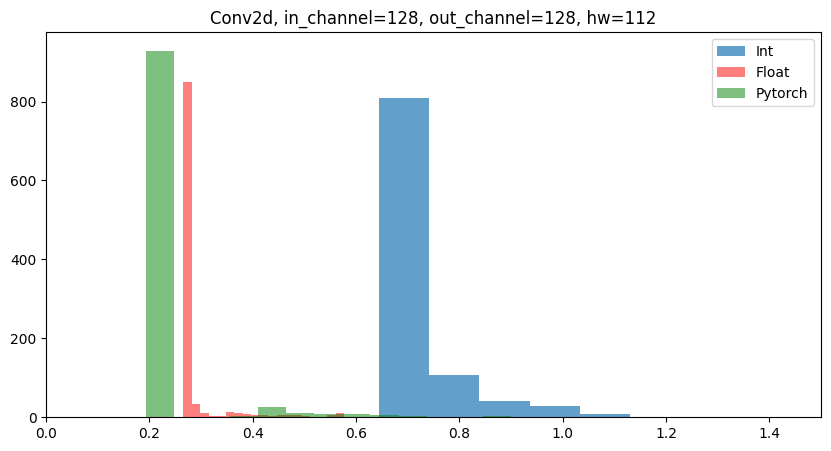

In [23]:
plt.figure(figsize=(10,5))
print(len(conv3_int), len(conv3_float), len(conv3_pytorch))
plt.hist(conv3_int, bins=50, alpha=0.7, histtype='stepfilled', label='Int')
plt.hist(conv3_float, bins=50, alpha=0.5, histtype='stepfilled', color='red', label='Float')
plt.hist(conv3_pytorch, bins=50, alpha=0.5, histtype='stepfilled', color='green', label='Pytorch')
plt.legend()
plt.title("Conv2d, in_channel=128, out_channel=128, hw=112")
plt.xlim(0,1.5)
plt.show()

In [21]:
plt.figure(figsize=(10,5))
plt.hist(linear1_int, bins=50, alpha=0.7, histtype='stepfilled', label='Int')
plt.hist(linear1_float, bins=50, alpha=0.5, histtype='stepfilled', color='red', label='Float')
plt.hist(linear1_pytorch, bins=50, alpha=0.5, histtype='stepfilled', color='green', label='Pytorch')
plt.legend()
# plt.xlim(0,1)
plt.show()

NameError: name 'linear1_int' is not defined

<Figure size 1000x500 with 0 Axes>

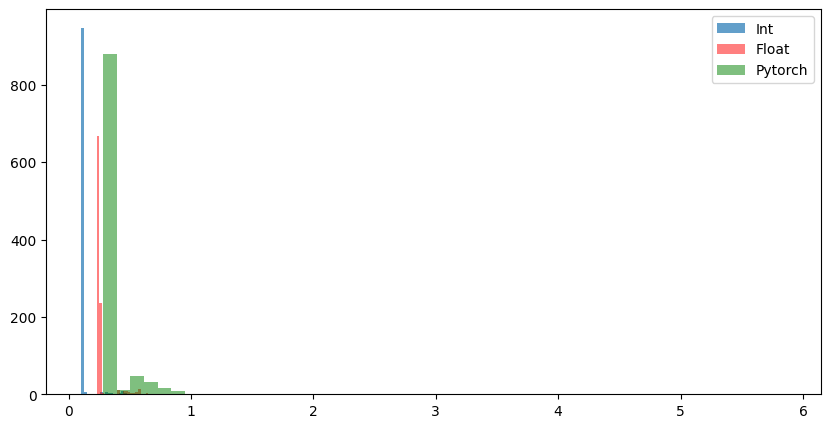

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(linear2_int, bins=50, alpha=0.7, histtype='stepfilled', label='Int')
plt.hist(linear2_float, bins=50, alpha=0.5, histtype='stepfilled', color='red', label='Float')
plt.hist(linear2_pytorch, bins=50, alpha=0.5, histtype='stepfilled', color='green', label='Pytorch')
plt.legend()
plt.show()

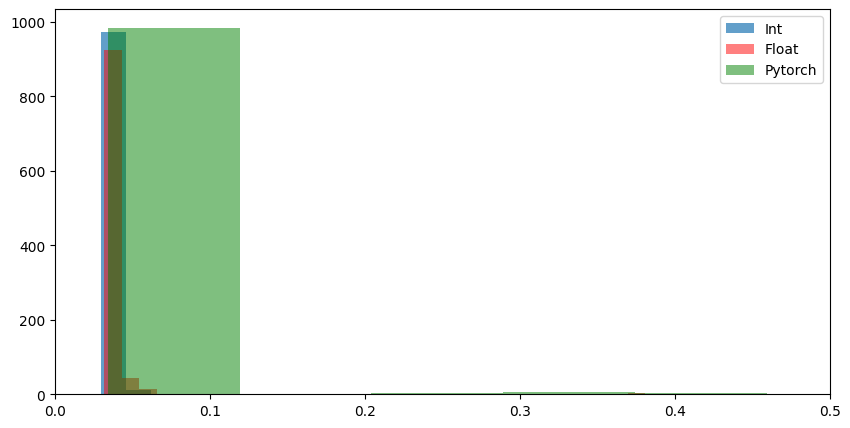

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(linear3_int, bins=50, alpha=0.7, histtype='stepfilled', label='Int')
plt.hist(linear3_float, bins=50, alpha=0.5, histtype='stepfilled', color='red', label='Float')
plt.hist(linear3_pytorch, bins=50, alpha=0.5, histtype='stepfilled', color='green', label='Pytorch')
plt.legend()
plt.xlim(0, 0.5)
plt.show()

In [ ]:
from models import layers

